In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT

from analysis import PandasAnalysis

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/onelep/output/Run2/*.root")
babies

['../analysis/studies/onelep/output/Run2/TTX.root',
 '../analysis/studies/onelep/output/Run2/Bosons.root',
 '../analysis/studies/onelep/output/Run2/VHToNonbb.root',
 '../analysis/studies/onelep/output/Run2/TTbar2L.root',
 '../analysis/studies/onelep/output/Run2/WJets.root',
 '../analysis/studies/onelep/output/Run2/TTbar1L.root',
 '../analysis/studies/onelep/output/Run2/VBSWH_mkW.root']

In [3]:
vbswh = PandasAnalysis(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=["xsec_sf"]
)

In [4]:
vbswh.set_split_column(ratio=0.75, name="split")

In [5]:
vbswh.df.columns

Index(['lep_pdgID', 'lep_pt', 'lep_eta', 'lep_phi', 'LT', 'hbbjet_score',
       'hbbjet_pt', 'hbbjet_eta', 'hbbjet_phi', 'hbbjet_mass',
       'hbbjet_msoftdrop', 'xsec_sf', 'event', 'MET', 'ST', 'lep_sf',
       'lep_sf_up', 'lep_sf_dn', 'HT', 'n_jets_pt30', 'n_fatjets',
       'n_loose_b_jets', 'n_medium_b_jets', 'n_tight_b_jets', 'ld_vbs_jet_pt',
       'tr_vbs_jet_pt', 'M_jj', 'deta_jj', 'dR_jj', 'name', 'is_signal',
       'event_weight', 'split', 'split_weight'],
      dtype='object')

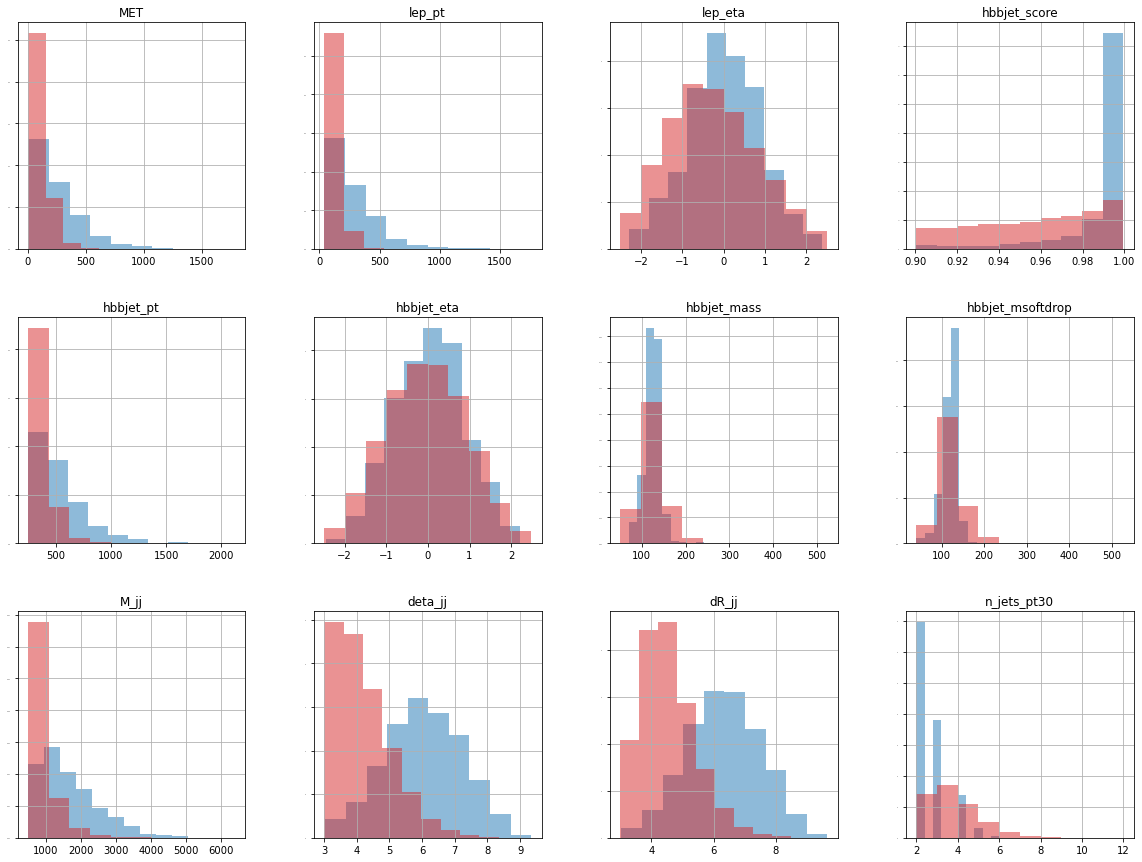

In [24]:
# # Select features
features = [
    "MET",
    "lep_pt",
    "lep_eta",
    "hbbjet_score",
    "hbbjet_pt",
    "hbbjet_eta",
    "hbbjet_mass",
    "hbbjet_msoftdrop",
    "M_jj",
    "deta_jj",
    "dR_jj",
    "n_jets_pt30"
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(20,15))

sig_df = vbswh.sig_df()
bkg_df = vbswh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [7]:
train_df = vbswh.df[vbswh.df.split].sample(frac=1.)
test_df = vbswh.df[~vbswh.df.split].sample(frac=1.)

# BDT Input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
params = {}
params["objective"] = "binary:logistic"

# BDT Knobs (Parameters)
num_round = 500                  # Number of training rounds
params["eta"] = 0.1              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 8.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [8]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.93211	eval-auc:0.91525
[1]	train-auc:0.94539	eval-auc:0.94133
[2]	train-auc:0.94719	eval-auc:0.94654
[3]	train-auc:0.95272	eval-auc:0.95251
[4]	train-auc:0.95949	eval-auc:0.96044
[5]	train-auc:0.96239	eval-auc:0.96438
[6]	train-auc:0.96316	eval-auc:0.96513
[7]	train-auc:0.96482	eval-auc:0.96608
[8]	train-auc:0.96626	eval-auc:0.96804
[9]	train-auc:0.96707	eval-auc:0.96853
[10]	train-auc:0.96889	eval-auc:0.97054
[11]	train-auc:0.96870	eval-auc:0.97025
[12]	train-auc:0.97041	eval-auc:0.97138
[13]	train-auc:0.97069	eval-auc:0.97191
[14]	train-auc:0.97144	eval-auc:0.97130
[15]	train-auc:0.97263	eval-auc:0.97273
[16]	train-auc:0.97385	eval-auc:0.97399
[17]	train-auc:0.97477	eval-auc:0.97569
[18]	train-auc:0.97537	eval-auc:0.97625
[19]	train-auc:0.97594	eval-auc:0.97651
[20]	train-auc:0.97621	eval-auc:0.97668
[21]	train-auc:0.97676	eval-auc:0.97755
[22]	train-auc:0.97685	eval-auc:0.97777
[23]	train-auc:0.97741	eval-auc:0.97842
[24]	train-auc:0.97788	eval-auc:0.97904
[25]	train

In [9]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


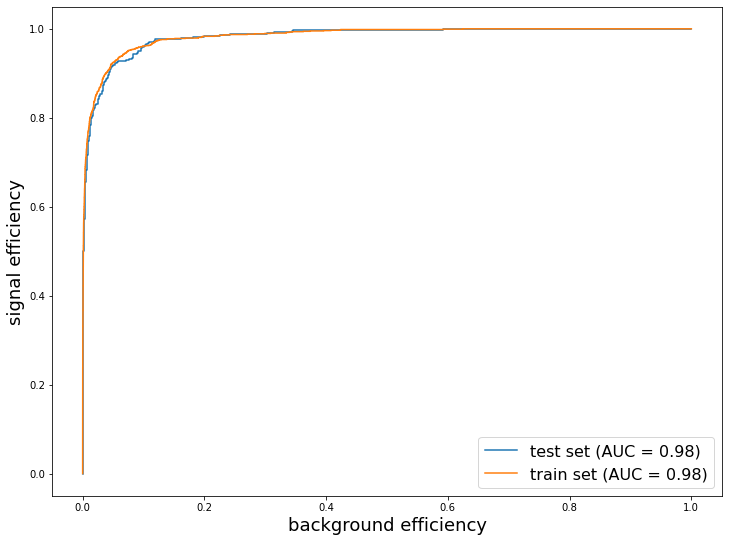

In [10]:
fig, axes = plt.subplots(figsize=(12,9))

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency", size=18);
plt.ylabel("signal efficiency", size=18);
plt.legend(fontsize=16);

In [11]:
vbswh.df["bdt"] = bst.predict(xgb.DMatrix(vbswh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


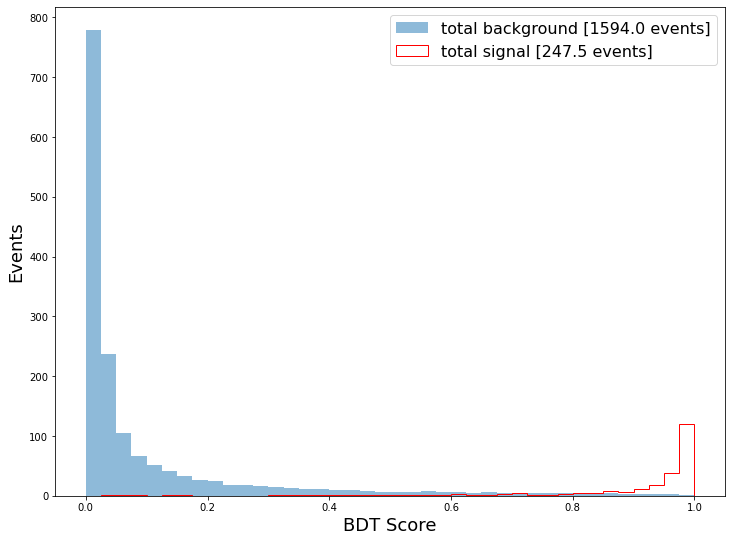

In [12]:
axes = vbswh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 41), xlabel="BDT Score")

In [13]:
vbswh.mini_sig_scan("bdt", [0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98])

sel,sig,bkg
bdt > 0.8,208.73446655273438,25.742897033691406
bdt > 0.9,186.413330078125,10.32880973815918
bdt > 0.91,182.571533203125,8.910545349121094
bdt > 0.92,177.92811584472656,7.7480549812316895
bdt > 0.93,172.30499267578125,5.8143157958984375
bdt > 0.94,166.6751708984375,4.818088531494141
bdt > 0.95,157.19920349121094,3.4962852001190186
bdt > 0.96,147.8487091064453,2.5756704807281494
bdt > 0.97,130.10968017578125,1.3204286098480225
bdt > 0.98,104.9375,0.5788748860359192


In [14]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.1
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,8.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,6.697506427764893


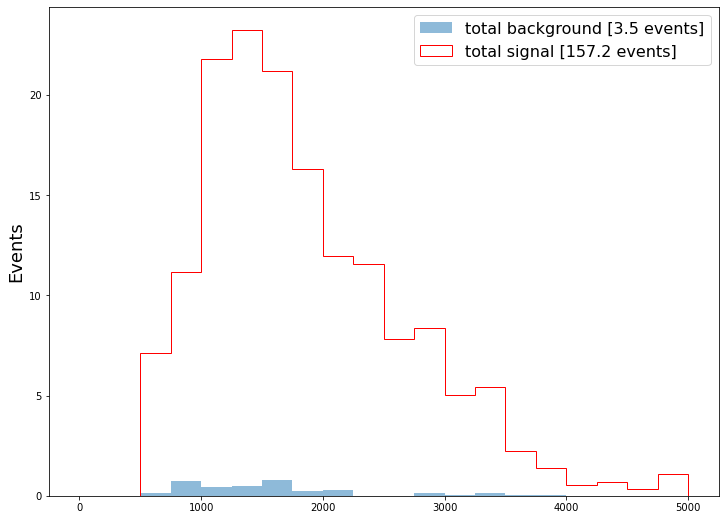

In [17]:
vbswh.plot_sig_vs_bkg("M_jj", np.linspace(0, 5000, 21), selection="bdt > 0.95")

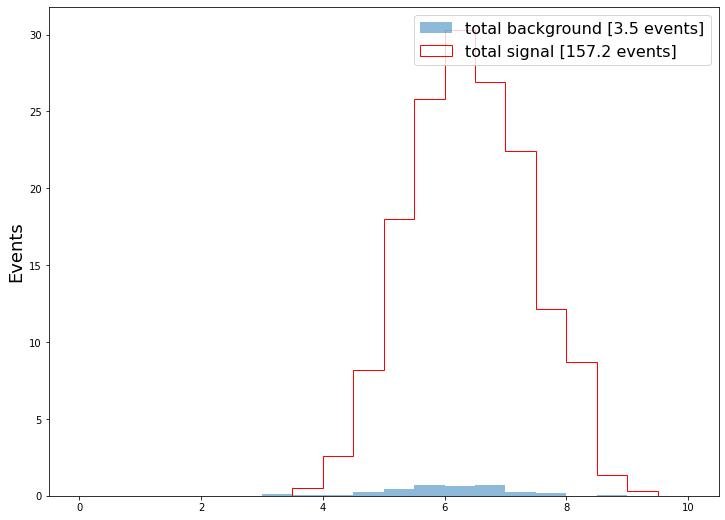

In [20]:
vbswh.plot_sig_vs_bkg("deta_jj", np.linspace(0, 10, 21), selection="bdt > 0.95")

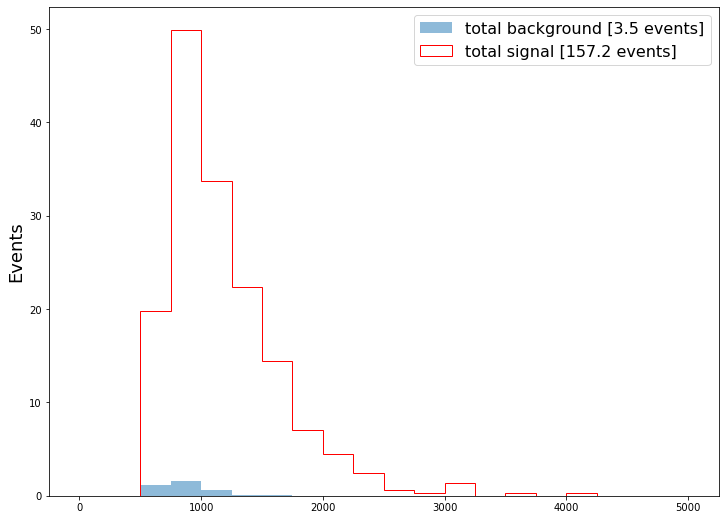

In [18]:
vbswh.plot_sig_vs_bkg("ST", np.linspace(0, 5000, 21), selection="bdt > 0.95")

In [22]:
vbswh.mini_sig_scan("ST", [800, 900, 1000, 1100, 1200], base_selection="bdt > 0.95")

sel,sig,bkg
bdt > 0.95 and ST > 800,127.9104232788086,1.6534898281097412
bdt > 0.95 and ST > 900,106.3653564453125,1.0936143398284912
bdt > 0.95 and ST > 1000,87.46891784667969,0.7433905005455017
bdt > 0.95 and ST > 1100,72.47874450683594,0.28518369793891907
bdt > 0.95 and ST > 1200,57.64191436767578,0.2446655035018921
